In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-colb8t9b
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-colb8t9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-6enahz0w/pydoe_f99ec408b21a4657b7f22324149b32f4
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-6enahz0w/pydoe_f99ec408b21a4657b7f22324149b32f4
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 316 kB 10.6 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=8193079309509f9f79ad2d3a7b846e52fcc6646d0dda67b27163577a12da3aad
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F21
from bayes_optim.search_space import RealSpace

In [4]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f21'
f = F21

samples = space.sample(50000)

In [5]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [6]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [7]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [8]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'cma_es_regret'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_init_regret'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'uniform_regret'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_regret'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'halton_regret'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'sobol_regret'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,2.040101,0,0.781008,1.640512,1.293377,1.945677,0.124528,74.136481,14.816716
1,2.001350,1,1.508079,1.497197,0.000019,1.876513,1.057082,67.967916,14.035363
2,0.312547,2,0.059103,1.308344,2.062354,0.014321,0.001151,69.674020,13.867276
3,0.000021,3,0.031800,0.122102,4.263554,2.925804,0.054090,79.964496,15.429284
4,1.426581,4,2.003578,1.477616,1.385505,0.142842,3.021603,67.876549,16.137666


# CMA-ES vs first individual (generated by LHS)

In [9]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES improved lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
3,3,0.000021,0.054090
4,4,1.426581,3.021603
5,5,0.000080,0.829551
7,7,0.565978,1.510823
8,8,0.261284,0.989150
11,11,1.894104,1.894352
16,16,1.390439,1.573401
18,18,0.048374,1.553685
20,20,0.000109,0.114835
22,22,1.992640,2.030927


In [10]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES worstened lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
0,0,2.040101,0.124528
1,1,2.001350,1.057082
2,2,0.312547,0.001151
6,6,2.308872,1.153547
9,9,1.443118,0.601055
10,10,1.624026,0.848313
12,12,1.012498,0.100454
13,13,0.442997,0.134668
14,14,2.012146,0.014895
15,15,0.042732,0.014759


# CMA-ES generated vs Uniform

In [11]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 22, (44.0%) function instances


,f_s,cma_es_regret,uniform_regret
3,3,0.000021,0.031800
4,4,1.426581,2.003578
5,5,0.000080,0.003356
7,7,0.565978,1.885525
8,8,0.261284,2.045049
10,10,1.624026,1.733087
15,15,0.042732,0.198722
18,18,0.048374,2.927704
20,20,0.000109,0.360539
24,24,1.469178,1.953017


# CMA-ES vs LHS

In [12]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret']]

DoE generated by CMA-ES is better than lhs sampled DoE on 22 (44.0%) function instances


,f_s,cma_es_regret,lhs_regret
2,2,0.312547,1.308344
3,3,0.000021,0.122102
4,4,1.426581,1.477616
5,5,0.000080,0.124376
8,8,0.261284,1.589899
10,10,1.624026,1.743485
12,12,1.012498,1.105774
15,15,0.042732,1.657484
16,16,1.390439,1.938734
17,17,1.891926,2.078202


# CMA-ES vs Sobol

In [13]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret']]

DoE generated by CMA-ES is better than sobol generated DoE on 16 (32.0%) function instances


,f_s,cma_es_regret,sobol_regret
2,2,0.312547,2.062354
3,3,0.000021,4.263554
5,5,0.000080,2.029054
7,7,0.565978,0.853740
12,12,1.012498,1.983424
15,15,0.042732,1.934478
18,18,0.048374,0.351375
20,20,0.000109,0.012078
28,28,0.501183,1.334059
29,29,0.000006,1.961899


# CMA-ES vs Halton

In [14]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret']]

DoE generated by CMA-ES is better than halton generated DoE on 18 (36.0%) function instances


,f_s,cma_es_regret,halton_regret
3,3,0.000021,2.925804
5,5,0.000080,2.028212
8,8,0.261284,0.629061
10,10,1.624026,2.048777
12,12,1.012498,1.607579
13,13,0.442997,1.112633
18,18,0.048374,0.052556
20,20,0.000109,0.331965
25,25,1.673930,2.038604
28,28,0.501183,1.772048


In [15]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 8 (16.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
3,0.000021,3,0.031800,0.122102,4.263554,2.925804,0.054090,79.964496,15.429284
5,0.000080,5,0.003356,0.124376,2.029054,2.028212,0.829551,74.068774,14.713717
18,0.048374,18,2.927704,0.479912,0.351375,0.052556,1.553685,69.754231,18.271951
20,0.000109,20,0.360539,1.981985,0.012078,0.331965,0.114835,78.299885,16.303341
28,0.501183,28,2.118033,1.832817,1.334059,1.772048,0.006593,70.220236,17.290025
29,0.000006,29,2.035080,1.800279,1.961899,0.488455,0.001732,64.644584,15.053394
32,0.003109,32,1.340244,0.496552,1.993429,0.901151,0.052211,66.524413,15.786906
37,0.069096,37,2.294196,1.359141,0.716645,1.773887,1.195531,70.428540,14.982804


In [16]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniform is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniform is the best on 10 (20.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,2.040101,0,0.781008,1.640512,1.293377,1.945677,0.124528,74.136481,14.816716
11,1.894104,11,0.009804,0.959220,0.086503,1.766429,1.894352,67.437227,16.548167
12,1.012498,12,0.159256,1.105774,1.983424,1.607579,0.100454,71.892260,17.071615
17,1.891926,17,0.014870,2.078202,1.576031,0.602337,0.014612,71.637503,16.597969
19,2.024754,19,0.072809,2.059869,1.942137,1.577211,0.751687,67.047856,14.956329
21,1.396499,21,0.003062,1.849402,1.053770,0.873950,1.145295,68.370629,13.749020
25,1.673930,25,0.012212,0.016463,0.096177,2.038604,0.014838,64.434563,14.798649
26,1.775639,26,0.001051,1.656648,0.032639,1.688764,0.513624,71.953781,15.343829
44,1.333505,44,0.014104,0.045632,2.025806,1.116743,1.906292,62.144324,13.651289
47,1.576736,47,0.018143,0.940256,1.501820,1.395046,2.694609,65.802227,14.977683


In [17]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton is the best on 9 (18.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
2,0.312547,2,0.059103,1.308344,2.062354,0.014321,0.001151,69.674020,13.867276
4,1.426581,4,2.003578,1.477616,1.385505,0.142842,3.021603,67.876549,16.137666
6,2.308872,6,1.303668,2.106749,1.982067,0.755047,1.153547,68.602111,16.006832
7,0.565978,7,1.885525,0.304081,0.853740,0.022876,1.510823,65.288506,15.930473
15,0.042732,15,0.198722,1.657484,1.934478,0.014665,0.014759,69.839354,17.218953
30,2.008298,30,0.539172,0.843414,1.712544,0.003656,0.040338,57.405310,14.228601
34,1.517048,34,0.003592,0.994169,0.015727,0.000028,0.016592,63.083762,15.301705
36,1.110887,36,1.372419,1.053002,3.891461,0.439326,1.966777,67.256860,14.730879
48,1.647458,48,1.869262,1.452058,0.016355,0.009043,0.043653,55.633380,14.050486


In [18]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 10 (20.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
9,1.443118,9,0.034877,0.007981,1.067959,0.153538,0.601055,68.019375,14.750256
13,0.442997,13,0.003291,0.000251,0.018414,1.112633,0.134668,60.530217,13.988627
14,2.012146,14,1.618151,0.042098,0.151659,0.587183,0.014895,65.502587,13.788803
23,2.605462,23,1.096425,0.360502,0.559466,1.727184,1.556399,65.517685,14.445380
33,1.579150,33,0.190260,0.000037,0.040640,0.242595,1.840251,69.010695,14.897996
38,0.482497,38,0.934083,0.123616,1.375407,0.489900,0.068998,74.817584,16.046265
39,0.671792,39,2.016562,0.007466,1.690768,0.139861,2.204895,67.599093,16.579826
40,2.042931,40,1.696314,0.008344,0.011490,0.011233,0.511144,72.314609,16.446721
41,1.704378,41,1.899011,0.814122,1.003804,2.020599,2.062198,69.528142,15.263127
46,2.212875,46,0.913389,0.164776,1.079658,1.992594,1.711656,71.835303,14.555011


In [19]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 8 (16.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,2.040101,0,0.781008,1.640512,1.293377,1.945677,0.124528,74.136481,14.816716
2,0.312547,2,0.059103,1.308344,2.062354,0.014321,0.001151,69.674020,13.867276
12,1.012498,12,0.159256,1.105774,1.983424,1.607579,0.100454,71.892260,17.071615
14,2.012146,14,1.618151,0.042098,0.151659,0.587183,0.014895,65.502587,13.788803
17,1.891926,17,0.014870,2.078202,1.576031,0.602337,0.014612,71.637503,16.597969
28,0.501183,28,2.118033,1.832817,1.334059,1.772048,0.006593,70.220236,17.290025
31,1.956582,31,1.022134,1.266693,0.470474,1.920708,0.000450,65.368216,14.276092
38,0.482497,38,0.934083,0.123616,1.375407,0.489900,0.068998,74.817584,16.046265


In [20]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol is the best on 13 (26.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
1,2.001350,1,1.508079,1.497197,0.000019,1.876513,1.057082,67.967916,14.035363
8,0.261284,8,2.045049,1.589899,0.000541,0.629061,0.989150,80.561351,14.084230
10,1.624026,10,1.733087,1.743485,0.017327,2.048777,0.848313,68.743358,14.051841
16,1.390439,16,0.663463,1.938734,0.504459,0.886686,1.573401,72.516376,15.425592
22,1.992640,22,0.732634,0.256109,0.001940,0.699413,2.030927,61.102885,13.940238
24,1.469178,24,1.953017,2.707048,0.000218,0.002830,1.957251,71.189326,14.775917
27,0.124474,27,0.099355,1.969942,0.003969,0.011164,1.560529,67.335715,14.677363
31,1.956582,31,1.022134,1.266693,0.470474,1.920708,0.000450,65.368216,14.276092
35,2.116017,35,0.479671,0.504827,0.013645,1.695428,2.021015,71.802390,15.446590
42,0.292722,42,2.073155,1.329865,0.065670,0.753269,1.283388,60.187978,14.829351


([<matplotlib.axis.XTick at 0x7f5301832850>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

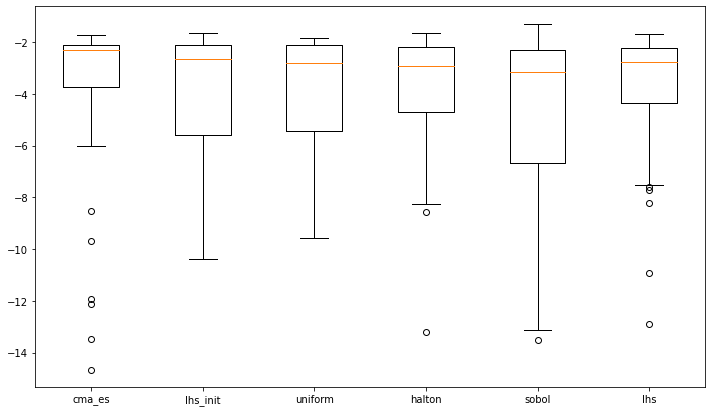

In [21]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7f53012cff90>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

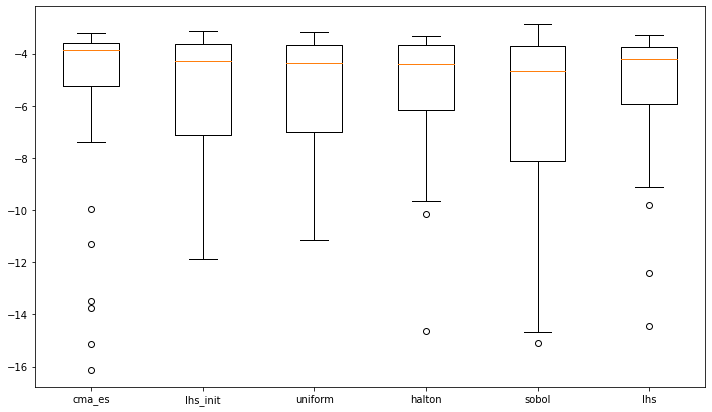

In [22]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)